## Clusteranalyse

Die Clusteranalyse ist ein Verfahren, um ähnliche Messungen zu bündeln. Sie hilft uns Auswirkungen *ungemessener* Variablen auf die gemessenen Variablen festzustellen. Weil die Clusteranalyse Werte gruppiert und nicht wie die PCA in Vektoren zusammenfasst, ist die Interpretation der Ergebnisse oft leichter. Die Interpretation wird dadurch unterstützt, dass die Datensätze in einem Cluster Gemeinsamkeiten aufweisen. Diese Gemeinsamkeiten geben uns Hinweise, wie diese Datensätze zusammenhängen können. 

> Definition: Ein **Cluster** bezeichnet eine *Gruppe von Datensätzen*, die sich mit Bezug auf die untersuchten Vektoren ähneln.

Die Clusteranalyse arbeitet wie die PCA mit Hilfe der Varianz. Die Clusteranalyse gruppiert Datensätze über die untersuchten Vektoren, indem die Varianz innerhalb eines Clusters minimiert wird und die Varianz zwischen Clustern maximiert wird. Die Datensätze in einem Cluster sind also *homogen* und die Cluster sind zueinander *heterogen*. 

Es gibt zwei Zugänge zur Clusteranalyse. 

1. Die hierarchische Clusteranalyse
2. Die partitionierende Clusteranalyse

### Vorbereitungen 

In [206]:
library(tidyverse) 
library(tidymodels)

# Funktionen für die Clusteranalyse
library(cluster)

# Visualisierung von Clustern
library(ggforce)

In [2]:
noten = read_csv2("../../../Deskriptive_statistik/notenspiegel.csv") 

ℹ Using "','" as decimal and "'.'" as grouping mark. Use `read_delim()` for more control.

Rows: 88 Columns: 8
── Column specification ──────────────────────────────────────────────────────────
Delimiter: ";"
dbl (8): Lum, Lkm, Lgm, Luct, Lkct, Lgct, Lg, Lg_gerundet

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Der folgende Code führt eine PCA durch. Das Problem einer PCA ist, dass wir die ermittelten Dimensionen nur schlecht interpretieren können. Die Methode eigenet sich aber sehr gut, um komplexe Daten auf wenige(r) Dimentionen zu reduzieren. 

In [193]:
noten %>%
    select(ends_with("ct")) %>% 
    mutate(
        TN = row_number()
    ) -> notenTN

notenTN %>% 
    select(ends_with("ct")) %>% 
    prcomp() -> NotenKomponenten

NotenKomponenten %>%
    pluck("x") %>%
    as_tibble(rownames = "TN") %>%
    mutate(
        TN = as.integer(TN) # lästig, aber Zeilennamen sind in R immer Zeichenketten. 
    ) %>%
    full_join(notenTN) -> NotenUndKomponenten


Joining, by = "TN"


In [411]:
notenTN %>%
    select(ends_with("ct")) -> notenMatrix 

### Hierarchische Clusteranalyse

Die hierarchische Clusteranalyse ist eine sog. "Bottom-up"-Methode, die ausgehend von den einzelnen Datensätzen schrittweise die Cluster so bündelt, dass grössere Cluster mit etwa der gleichen Varianz entstehen. Die verschiedenen Vorgehensweisen bei diesem Schrittweisen bündeln wird in Bortz und Schuster (2010, S. 459f) beschrieben. Für die Arbeit mir R sind die folgenden Vorgehensweisen von Bedeutung: 

- Minimalmethode (`single`) 
- Maximalmethode (`complete`)
- Durchschnittsmethode (`average`)
- Verallgemeinerte Durchschnittsmethode (`flexible`)
- Ward's Methode (`ward`)

Die genaue Vorgehensweise der hierarchischen Clusteranalyse wird uns in R durch die Funktion `agnes()` aus der Bibliothek `cluster` abgenommen. 

Anders als die base-R `hclust()` Funktion kann `agnes()` mit grossen Daten effizient umgehen. `hclust()` kann nur Daten bis zu einem Gesamtumfang von ca. 62000 Werten auswerten. Unsere 88 Datensätze mit 3 Vektoren führen zu einer Matrix mit $$ (3 \cdot 88)^2 $$ Werten. Das sind knapp 69000 Werte. 


In [403]:
(88*3)^2

[1] 69696


Im folgenden Beispiel wird Ward's Methode verwendet, weil diese konsistente und relativ leicht zu interpretierende Cluster bildet. 

In [412]:
notenMatrix %>%
    agnes(method = "ward") -> clusterErgebnisH

Das Ergebnis einer hierarchischen Clusteranalyse ist ein Baum, der sich zu den einzelnen Datensätzen hin verästelt. Werfen wir einen kurzen Blick auf diese Struktur und lassen sie uns als *Dendrogramm* anzeigen. 

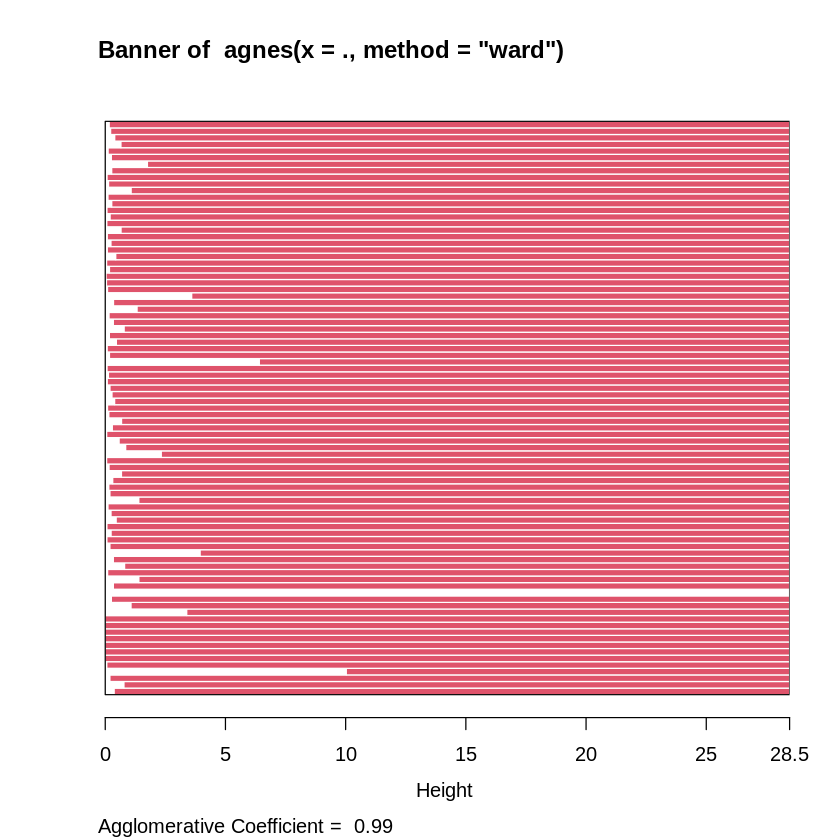

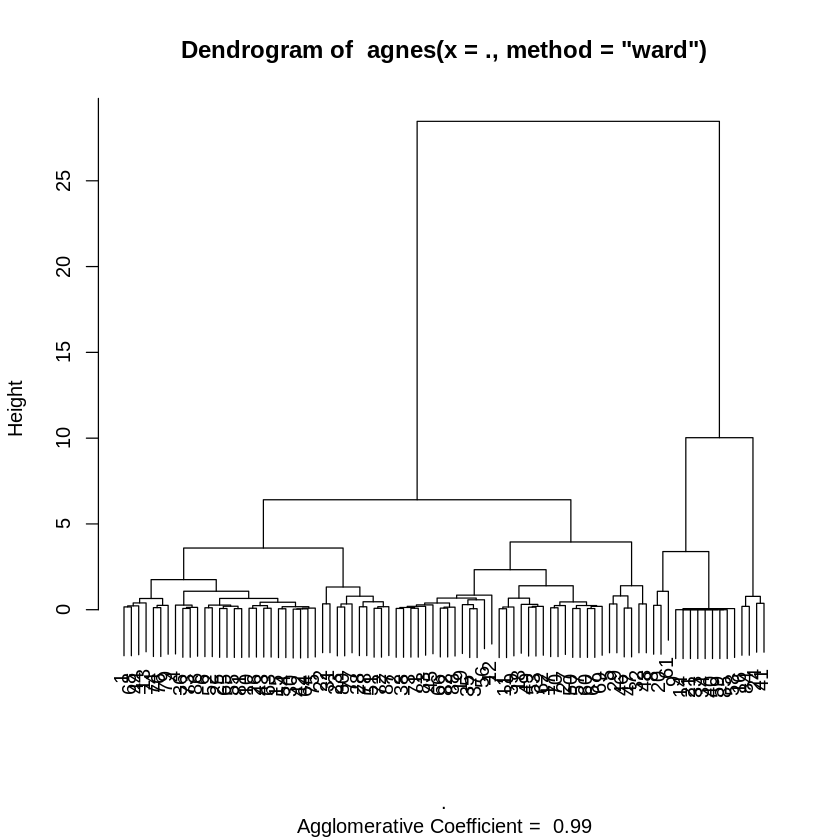

In [347]:
clusterErgebnisH %>% plot()

Dieses sog. Dendrogramm zeigt uns, dass ab einer Höhe von ca. 27 keine Clusterdifferenzierung mehr vorliegt. **In der Regel werden wir das Dendrogramm nicht in unseren Bericht aufnehmen.** 

Mit der Funktion `cutree()` können wir uns die Cluster auf einer bestimmten Höhe ausgeben lassen. Die Höhe `0` entspricht den einzelnen Werten, die Höhe `1` sind die Cluster auf der ersten Stufe, usw. Das bedeutet, dass wir Cluster auf jeder Höhe erhalten werden. 

Welche Cluster sollen wir am Besten auswählen und präsentieren? 

Dazu wählen wir die sog. Ellenbogenmethode an. Wir visualisieren dazu die Anzhal der Cluster auf einer bestimmten Höhe. Diese Kurve hat bei kleinen Höhen immer einen steilen Teil und mit zunehmender Höhe flacht die Kurve ab. Die Höhe ist nach dieser Methode *optimal*, wenn diese Kurve vom steilen Teil in den Flachen übergeht.

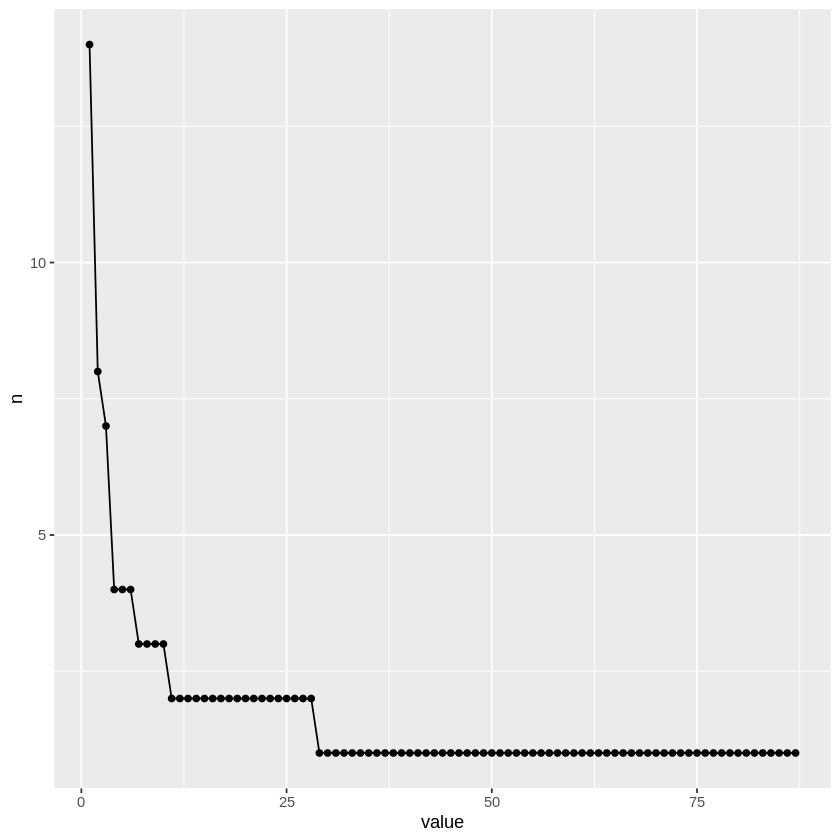

In [398]:
clusterErgebnisH %>% pluck("height") %>% length() -> nheights

seq(length = nheights) %>% as_tibble() %>% 
    group_by(value) %>% 
    mutate(
        n = clusterErgebnisH %>% cutree(h = value) %>% unique() %>% length() 
    ) %>%
    ungroup() %>%
    ggplot(aes(value, n)) + geom_point() + geom_line()

In unserem Fall flacht die Kurve deutlich ab einer Höhe von `4` ab. Dieses Abflachen bedeutet, dass die Informationen in den Clustern ab dieser Höhe immer weniger Informationen beitragen. 

Wir lassen uns also die Cluster auf der Höhe `4` ausgeben. Das Ergebnis wandeln wir in ein Stichprobenobjekt um und verknüpfen es mit dem Ergebnis der initialen PCA. 

In [399]:
clusterErgebnis %>% 
    cutree(h = 4) %>%
    enframe( name = "TN", value = "cluster") %>% 
    mutate( TN = TN %>% as.integer() ) %>%
    full_join(NotenUndKomponenten) -> ClusterNoten

Joining, by = "TN"


Visualisieren wir die Cluster in der PCA-Komponenten-Darstellung. 

Um die Cluster hervorzuheben, verwende ich die die Funktion `geom_mark_hull()` aus der Bibliothek `ggforce`. Diese Funktion rahmt die Punkte ein, die zu einem Cluster gehören. 

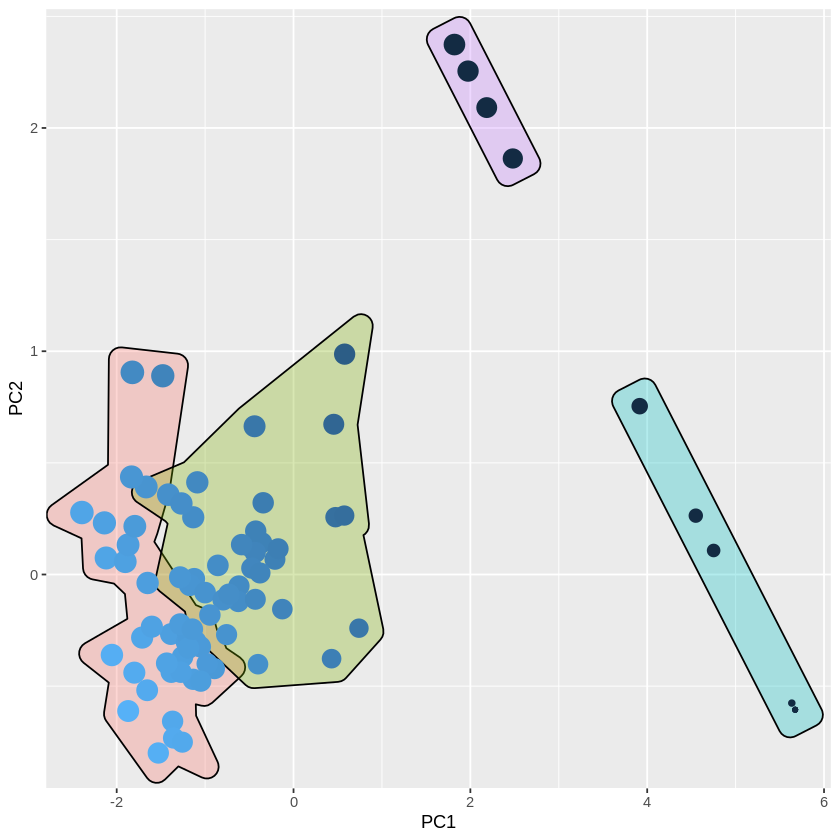

In [400]:
ClusterNoten %>% 
    ggplot(aes(PC1, PC2)) + 
        geom_mark_hull(aes(fill = factor(cluster))) +
        geom_point(aes(size = Luct, color = Lkct)) +
        theme(
            legend.position = "none"
        )

Gemeinsam mit den Daten der PCA können wir nun die Ergebnisse diffenzierter interpretieren. 

> Im Gegensatz zur PCA, ist es bei bei der Interpretation der Cluster-Analyse-Ergebnisse üblich, die Cluster nach gemeinsamen Eigenschaften  zu benennen.

- Das türkise Cluster verweist auf die Gruppe der Abbrechenden.
- Das violette Cluster zeigt auf die Teilnehmenden, die die Klausur nicht mitschreiben konnten. 
- Das grüne Cluster markiert die untere Leistungsgruppe. 
- Das rote Cluster kennzeichnet die obere Leistungsgruppe. 

Die Cluster im PCA-Plot zeigen uns, dass unsere naiv festgelegten Varaiblen zum Drop-out und den Krankmeldungen als Einflussgrössen auf die Leistungen sich auch empirisch finden lassen. Wir stellen aber auch fest, dass es innerhalb der Gruppe, die alle Leistungsnachweise erbracht hat, noch mindestens eine dritte unbeobachtete Variable existiert, die die Leistungsunterschiede erklärt könnte. 

### Partitionierende Clusteranalyse

Die partitionierende Clusteranalyse ist das zweite verbreitete Verfahren der Clusteranalyse. Bei diesem Verfahren handelt es sich um ein sog. *Top-down*-Verfahren. D.h. Es wird eine Clusterstruktur angenommen und auf die Daten angewandt. 

Im cluster Packet ist kmeans in der funktion `clara()` implementiert. Anders als die base-R `kmeans()`-Funktion gibt `clara()` den `wss`-Wert nicht zurück. kmeans kann mit `tot.withinss` die die Qualität der Cluster mit der "Ellbow"-Methode eingeschätzt werden. Die cluster Funktionen nutzen dafür die Funktion `clusGap()`. Diese Funktion scheint aber tendenziell mehr Cluster zu präferieren als ich visuelle erwarten würde.

Die angeblich einfachere `cluster::silhuette()` habe ich nicht zu einem Ergebnis bewegen können. 

Bei k-Means wird die Anzahl der Cluster `k` vorgegeben. Das Verfahren partitioniert die Daten so, dass sich genau `k`-Cluster ergeben. 

In [413]:
notenMatrix %>%
    kmeans(4)  -> clusterErgebnisP

In [407]:
clusterErgebnisP %>%
    pluck("cluster") %>% 
    enframe(name = "TN", value = "cluster") %>%
    full_join(NotenUndKomponenten) -> ClusterNotenKMeansP

Joining, by = "TN"


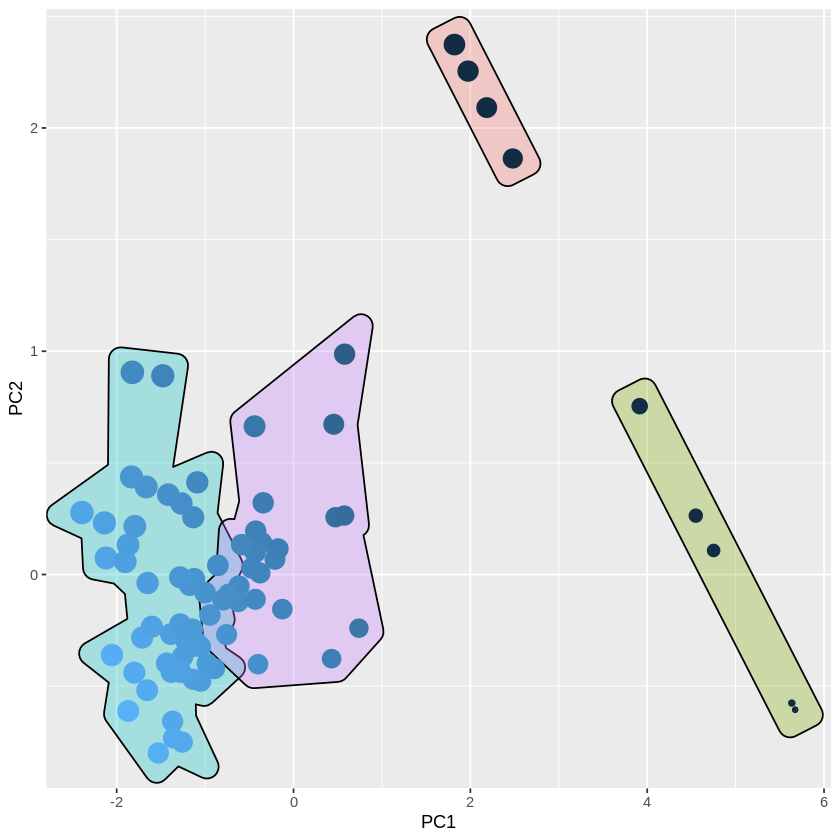

In [408]:
ClusterNotenKMeansP %>% 
    ggplot(aes(PC1, PC2)) + 
        geom_mark_hull(aes(fill = factor(cluster))) +
        geom_point(aes(size = Luct, color = Lkct)) +
        theme(
            legend.position = "none"
        )

k-Means findet ähnliche Cluster wie das Hierarchische Clustern. Die Unterschiede sind bei den vollständigen Noten. k-Means wählt das High-Performer Cluster grösser als `agnes()`.

Die Funktion `clara()` würde bei 4 Clustern eine andere Partitionierung wählen. 

Finde das beste Cluster -> Ellenbogenmethode via `tot.withinss` Dieser Wert fehlt in der `cluster` Bibliothek. 


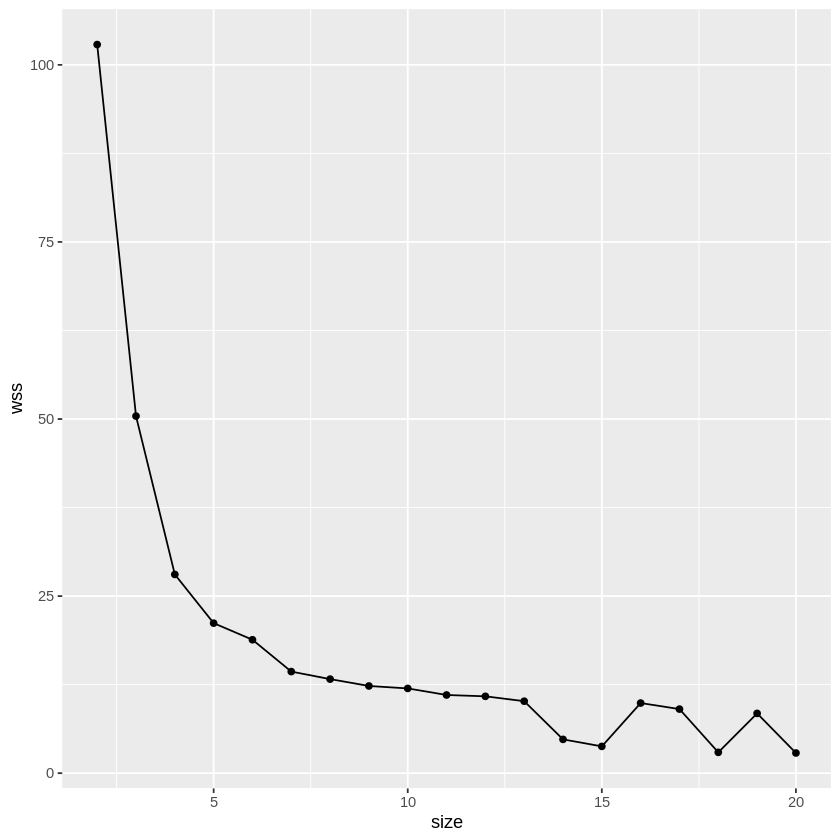

In [414]:
tibble(size = 2:20) %>%
    group_by(size) %>%
    mutate(
        wss = cMatrix %>% kmeans(size) %>% pluck("tot.withinss") 
    ) %>% 
    ggplot(aes(size, wss)) + geom_point() + geom_line()

Wir würden also wieder 4 Cluster auswählen
